# Introduction
This is my first Kaggle script and I chose to work with the Titanic dataset out of curiosity after spending some time surfing around the community. In this classic challenge I'll go from EDA to predictions in 8 steps as descripted below. 

Feedback is very welcome! Thank you for checking this kernel. 

## Steps taken for analysis:
1. Exploring data: Having a general overview on the data, do some basic analysis, look for missing values, etc...
2. Preparing data: Data cleaning and feature engineering
3. Selecting model/Training model: I'll try some of the most popular for binary classification problem
4. Evaluate model performance: Use validation set to assess model performance on unseen data and use metrics to compare different models
5. Tune parameters: I'll do it only for one model and use metrics to see if there were improvements
6. Error analysis: Examine validation set errors and see if I spot any systematic trend in types of error
7. Recalibrate model accounting findings from error analysis
8. Get predictions/results: Generate test set predictions and submit to evaluate performance

### Credits to: 
- https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/
- https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial#2.-Feature-Engineering
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

# Loading data

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
#Read the data
X = pd.read_csv("../input/titanic/train.csv")
X_test_full = pd.read_csv("../input/titanic/test.csv")

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


# **Exploring data**

In [2]:
#Shows the top few rows of training dataset
X.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#Check training data shape and columns
print('Training data shape = {}'.format(X.shape))
print('Training data columns = ', X.columns)
print('-------------------------------------------')
#Check test data shape and columns
print('Test data shape = {}'.format(X_test_full.shape))
print('Test data columns = \n', X_test_full.columns)

Training data shape = (891, 12)
Training data columns =  Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
-------------------------------------------
Test data shape = (418, 11)
Test data columns = 
 Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


## Exploring missing values

In [4]:
# check missing values in train data
print('<<Training set>>\n', X.isnull().sum())
print('---------------------------')
# check missing values in test data
print('<<Test set>>\n', X_test_full.isnull().sum())

<<Training set>>
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
---------------------------
<<Test set>>
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [5]:
# %of missing values for 'Age' column
print('Percent of missing "Age" values on training dataset:', '%.2f%%' % ((X['Age'].isnull().sum()/X.shape[0])*100))
# %of missing values for 'Embarked' column 
print('Percent of missing "Embarked" values on training dataset:', '%.2f%%' %((X['Embarked'].isnull().sum()/X.shape[0])*100))
# %of missing values for 'Cabin' column
print('Percent of missing "Cabin" values on training dataset:', '%.2f%%' %((X['Cabin'].isnull().sum()/X.shape[0])*100))
print('---------------------------')
# %of missing values for 'Age' column
print('Percent of missing "Age" values on test dataset:', '%.2f%%' % ((X_test_full['Age'].isnull().sum()/X_test_full.shape[0])*100))
# %of missing values for 'Fare' column 
print('Percent of missing "Fare" values on test dataset:', '%.2f%%' %((X_test_full['Fare'].isnull().sum()/X_test_full.shape[0])*100))
# %of missing values for 'Cabin' column
print('Percent of missing "Cabin" values on test dataset:', '%.2f%%' %((X_test_full['Cabin'].isnull().sum()/X_test_full.shape[0])*100))

Percent of missing "Age" values on training dataset: 19.87%
Percent of missing "Embarked" values on training dataset: 0.22%
Percent of missing "Cabin" values on training dataset: 77.10%
---------------------------
Percent of missing "Age" values on test dataset: 20.57%
Percent of missing "Fare" values on test dataset: 0.24%
Percent of missing "Cabin" values on test dataset: 78.23%


### Considerations for missing values: 
   - Missing values for training and test sets are very similar
   - 77% of data from 'Cabin' is missing. I think for the amount it is missing it would be reasonable to drop it but I still want to explore this data, even though most of it is missing. I suspect it can be related to the survivability chances.
   - A significant amount, 20% of 'Age' data is missing. We can imagine it might play a big role on survivability, it will need to be further analyzed to  determine how to impute these values. I'll explore name titles as it can represent age, social economic status... 
   - Only 2rows in 'Embarked' is missing value. So I'll just impute the most frequent port. 
   - I'll also treat the test data according to imputation strategy adopted for the training dataset.
   
## Correlation matrix between numerical values

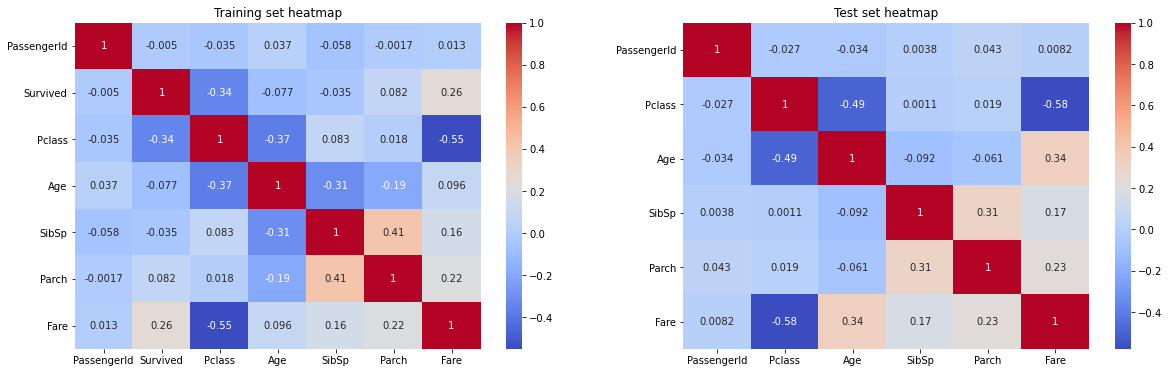

In [6]:
#check variable correlation 
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

sns.heatmap(X.corr(), ax=ax1, annot=True, cmap='coolwarm')
sns.heatmap(X_test_full.corr(), ax=ax2, annot=True, cmap='coolwarm')
ax1.set_title('Training set heatmap')
ax2.set_title('Test set heatmap')
plt.show()

Considering that correlation above |0.1| are relevant, we can observe that:
- The training set heatmap suggests survivability has the strongest correlation to **fare prices** and **ticket class**. It's something to keep in mind while exploring further more the data.
- On test set heatmap we see that correlation weights are fairly rebalanced as we don't know who survived or not. But is consistent to what is shown in training set heatmap. 

## Exploring Age feature

In [7]:
#Exploring 'Age'
X['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

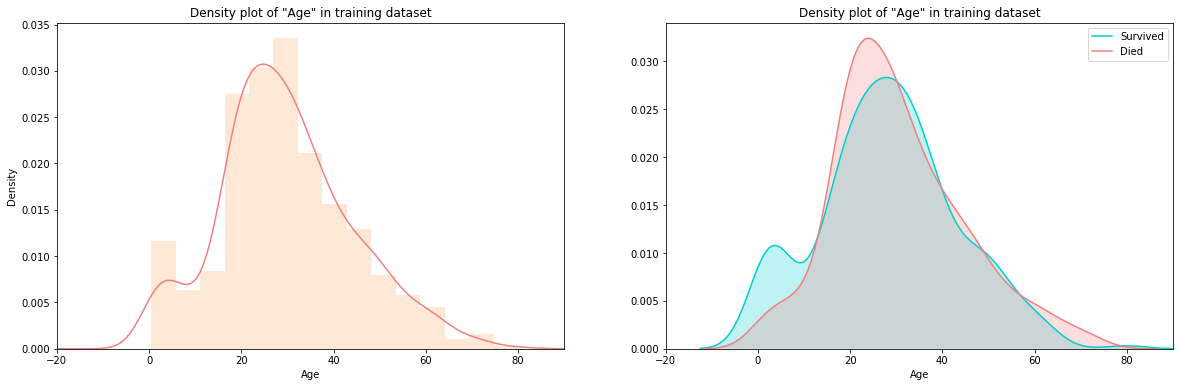

In [8]:
#check variable correlation 
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

#ax1: Density plot of training data (all)
graph = X['Age'].hist(bins=15, density=True, stacked=True, color='peachpuff', alpha=0.6, ax=ax1)
X['Age'].plot(kind='density', color='lightcoral', ax=ax1)
graph.set(xlabel='Age', xlim=(-20,90), title='Density plot of "Age" in training dataset')

#ax2: Density plot of training data by 'Survived'
graph2 = sns.kdeplot(X["Age"][X.Survived == 1], color="darkturquoise", shade=True, ax=ax2)
sns.kdeplot(X["Age"][X.Survived == 0], color="lightcoral", shade=True, ax=ax2)
ax2.legend(['Survived', 'Died'])
graph2.set(xlabel='Age', xlim=(-20,90), title='Density plot of "Age" in training dataset')

plt.show()

- From the density graphs we see that the distribution of survivors and deceased population is very similar and in general has the outline of a normal/gaussian distribution. 
- Also, we can note that a good part of the younger passengers survived, and the same pattern is not followed by the deceased population graph. My intuition is that children were given preference for a place in the safety boats.

We can take that in consideration when preparing data and differentiate younger passengers according to the age.

## Exploring Embarked feature

Grouped by port of embarkation:
S    644
C    168
Q     77
Name: Embarked, dtype: int64


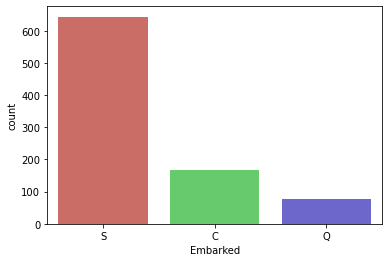

In [9]:
#Exploring 'Embarked'
print('Grouped by port of embarkation:')
print(X['Embarked'].value_counts())  

#plot according to counting
graph = sns.countplot(x='Embarked', data=X, palette="hls")
plt.show()

It's visually obvious most common port is S (Southhampton), so as I know only 2 training examples miss this value I'll impute the missing values with 'S', the most common port.

## Let's answer some questions
### How is the survival chance according to sex gender?

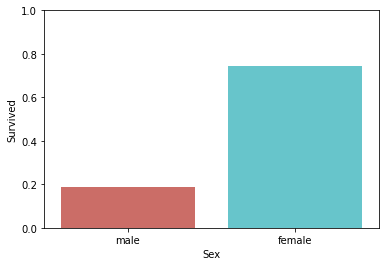

In [10]:
#plot survivors separated by gender
sns.barplot(x='Sex', y='Survived', data=X, palette="hls", ci=None);
plt.ylim(0,1)
plt.show()

In [11]:
# Rate of women and men who survived
women = X.loc[X.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

men = X.loc[X.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("Rate of women who survived:", "%.5f"% rate_women)
print("Rate of men who survived:", "%.5f"% rate_men)

Rate of women who survived: 0.74204
Rate of men who survived: 0.18891


The surviviability rate difference strongly suggests being a women meant better chances to survive. My intuition is that like the children, women/mothers were given preference for a place in te safety boats.

### How is the survival chance according to Ticket Class?

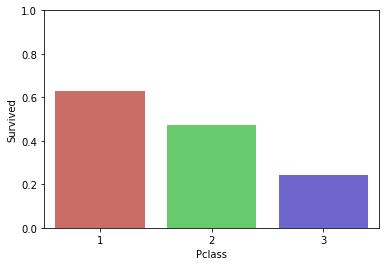

In [12]:
#plot survivors separated by ticket class
sns.barplot(x='Pclass', y='Survived', data=X, palette="hls", ci=None);
plt.ylim(0,1)
plt.show()

In [13]:
#Rate of ticket class according to survivors
first_class = X.loc[X.Pclass == 1]["Survived"]
first_rate = sum(first_class)/len(first_class)

second_class = X.loc[X.Pclass == 2]["Survived"]
second_rate = sum(second_class)/len(second_class)

third_class = X.loc[X.Pclass == 3]["Survived"]
third_rate = sum(third_class)/len(third_class)

print("Rate of 1st class who survived:", "%.5f"% first_rate)
print("Rate of 2nd class who survived:", "%.5f"% second_rate)
print("Rate of 3rd class who survived:", "%.5f"% third_rate)

Rate of 1st class who survived: 0.62963
Rate of 2nd class who survived: 0.47283
Rate of 3rd class who survived: 0.24236


The rate difference suggests that the ticket class also meant better chances to survive in the titanic disaster. It could be that the better ticket class implied a easier escape route giving better chances to escape.   

### Did having family onboard mean better chances of survival?

In [14]:
#Rate of who had siblings onboard and survived
sibs = X.loc[X.SibSp == 1]["Survived"]
sibs_rate = sum(sibs)/len(sibs)

parents = X.loc[X.Parch == 1]["Survived"]
parents_rate = sum(parents)/len(parents)

print("Rate of survivors with siblings:", "%.5f"% sibs_rate)
print("Rate of survivors with parents:", "%.5f"% parents_rate)

Rate of survivors with siblings: 0.53589
Rate of survivors with parents: 0.55085


As seen in the heatmap, 'SibSp' and 'Parch' presented strong correlation values. Seeing also that their survivability is not much different and knowing the common fact that both features mean to have a family member onboard, I'll create a new feature called **'FamilySize'** which will cover both given features. <br>
In **'FamilySize'**, 1 means self/lonely traveller and >1 means family members.

In [15]:
'''
Splits name from title and last name
param: df = dataframe column with name to be splitted
return: splitted name as a list
'''
def split_name(df): 
    name_title_list, lastname_list, name_list = [], [], []
    split_result = [name_title_list, lastname_list, name_list]
    for name in df:
        splited_name = name.split(", ")
        lastname = splited_name[0]
        restofname = splited_name[1]
        name_title = restofname.split(". ")
    
        name_title_list.append(name_title[0])
        lastname_list.append(lastname)
        name_list.append(restofname)
    
    split_result[0].append(name_title_list)
    split_result[1].append(lastname_list)
    split_result[2].append(name_list)
    del split_result[0][df.shape[0]]
    del split_result[1][df.shape[0]]
    del split_result[2][df.shape[0]]
    
    return split_result

#list of lists  
name = split_name(X['Name'])  
name_test = split_name(X_test_full['Name'])

In [16]:
#temporary dataframes, just for my convenience to manipulate data 
df = pd.DataFrame({'title':name[0], 'name':name[2], 'last_name' : name[1], 
                   'survived': X['Survived'], 'sibsp': X['SibSp'], 'parch': X['Parch'],
                  'age': X['Age'], 'sex': X['Sex']})
df_test = pd.DataFrame({'title':name_test[0], 'name':name_test[2], 'last_name' : name_test[1], 
                        'age': X_test_full['Age'], 'sex':X_test_full['Sex']})

df1 = df.copy() #NO relatives onboard
df2 = df.copy() #with relatives onboard
for row in range(891):
    if df1.loc[row,'sibsp']==0 and df1.loc[row,'parch']==0:
        df1.drop([row], inplace=True)
    if df2.loc[row,'sibsp']!=0 or df2.loc[row,'parch']!=0:
        df2.drop([row], inplace=True)

In [17]:
#Count family members according to their last name
df1['last_name'].value_counts()

Andersson        8
Sage             7
Carter           6
Skoog            6
Panula           6
                ..
Kink-Heilmann    1
Marvin           1
Wells            1
Robins           1
Jensen           1
Name: last_name, Length: 190, dtype: int64

In [18]:
#Rate of who survived, according to if it was lonely or had family onboard
fam = df1["survived"]
fam_rate = sum(fam)/len(fam)

lonely = df2["survived"]
lonely_rate = sum(lonely)/len(lonely)

print("Rate of survivors with family onboard:", "%.5f"% fam_rate)
print("Rate of survivors without family onboard:", "%.5f"% lonely_rate)

Rate of survivors with family onboard: 0.50565
Rate of survivors without family onboard: 0.30354


Considerations regarding the role of family onboard:
 - 190 different families were onboard
 - total_travelers = 891 (raw dataset rows)
 - family_travelers = 354 (39.73%)
 - lonely_travelers = 537 (60.27%)

Having a family also seems to play a role on survivability, 20% more chance of survival compared to lonely travelers. <br>
This will be taken into account on our model with the 'FamilySize' feature.

### Exploring Fare feature

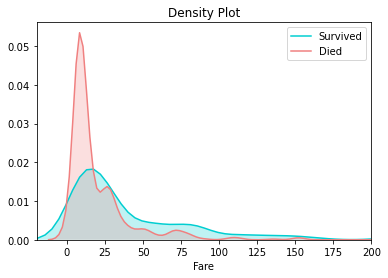

In [19]:
ax = sns.kdeplot(X['Fare'][X.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(X['Fare'][X.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot')
ax.set(xlabel='Fare')
plt.xlim(-20,200)
plt.show()

A lot of passengers that payed the cheapest fares (in the range around 0-25) died. My intuition is that the worst cabins were addressed to them.
Taking this into consideration I think binning this feature would be reasonable. I'll use feature scaling + normalization of features to make sure features are on a similar scale.

In [20]:
#Having a look into 'Fare' and 'Pclass'
X.groupby('Pclass').Fare.mean()

Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64

As expected, better ticket class implied on more costly fare prices.

### Does port of embarkation also played a role on survivability chances?
According to rates, who embarked from Cherbourg appears to have been most likely to survive, with around 15% to 20% more chance to survive.

In [21]:
emb_s = X.loc[X.Embarked == 'S']["Survived"]
s_rate = sum(emb_s)/len(emb_s)

emb_c = X.loc[X.Embarked == 'C']["Survived"]
c_rate = sum(emb_c)/len(emb_c)

emb_q = X.loc[X.Embarked == 'Q']["Survived"]
q_rate = sum(emb_q)/len(emb_q)

print("Rate of survivors that embarked from Southampton:", "%.5f"% s_rate)
print("Rate of survivors that embarked from Cherbourg:","%.5f"% c_rate)
print("Rate of survivors that embarked from Queenstown:","%.5f"% q_rate)

Rate of survivors that embarked from Southampton: 0.33696
Rate of survivors that embarked from Cherbourg: 0.55357
Rate of survivors that embarked from Queenstown: 0.38961


### Exploring Tickets

It's a high cardianality variable with too many unique values, 681 out of 891. <br>
Ticket value characterists: 
- number (ex. '349909')
- <char> number (ex. 'PP 9549')
- <char+.+/> number (ex. 'A/5 21171' or 'C.A. 34651')

In [22]:
X['Ticket'].value_counts()

347082              7
1601                7
CA. 2343            7
347088              6
CA 2144             6
                   ..
234818              1
111240              1
315088              1
112052              1
C.A./SOTON 34068    1
Name: Ticket, Length: 681, dtype: int64

### Looking into the correlation between 'Pclass' and 'Embarked'

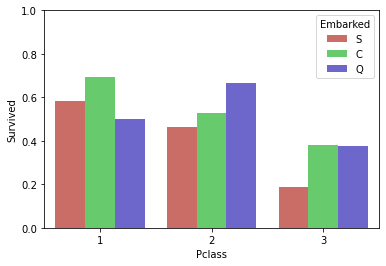

In [23]:
#plot survivors separated by ticket class
sns.barplot(x='Pclass', y='Survived', hue='Embarked', data=X, palette='hls', ci=None);
sns.set()
plt.ylim(0,1)
plt.show()

The plot suggests that,
- 1st and 2nd class passengers had a similar chance of survivability althought there is a difference of up to around 10% depending on the port of embarkation.
- Clearly the most affected ones were the 3rd class ticket passengers that embarked from S.

## Preparing data
### Exploring Name Titles to impute missing 'Age' values

In [24]:
#Name titles present in raw data
df.groupby('title').title.count()

title
Capt              1
Col               2
Don               1
Dr                7
Jonkheer          1
Lady              1
Major             2
Master           40
Miss            182
Mlle              2
Mme               1
Mr              517
Mrs             125
Ms                1
Rev               6
Sir               1
the Countess      1
Name: title, dtype: int64

The majoritary titles present are Mr, Mrs, Miss and Master. So those will be kept, while the remaining will be replaced.

In [25]:
#have a look on the titles to be substituted
df.loc[df.title.isin(['Major', 'Rev', 'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess', 'Don', 'Jonkheer', 'Sir', 'Dona'])]

,title,name,last_name,survived,sibsp,parch,age,sex
30,Don,Don. Manuel E,Uruchurtu,0,0,0,40.0,male
149,Rev,Rev. Thomas Roussel Davids,Byles,0,0,0,42.0,male
150,Rev,Rev. Robert James,Bateman,0,0,0,51.0,male
245,Dr,Dr. William Edward,Minahan,0,2,0,44.0,male
249,Rev,Rev. Ernest Courtenay,Carter,0,1,0,54.0,male
317,Dr,Dr. Ernest,Moraweck,0,0,0,54.0,male
369,Mme,Mme. Leontine Pauline,Aubart,1,0,0,24.0,female
398,Dr,Dr. Alfred,Pain,0,0,0,23.0,male
443,Ms,Ms. Encarnacion,Reynaldo,1,0,0,28.0,female
449,Major,Major. Arthur Godfrey,Peuchen,1,0,0,52.0,male


In [26]:
#Find mean age for each name title
df.groupby('title').age.mean()

title
Capt            70.000000
Col             58.000000
Don             40.000000
Dr              42.000000
Jonkheer        38.000000
Lady            48.000000
Major           48.500000
Master           4.574167
Miss            21.773973
Mlle            24.000000
Mme             24.000000
Mr              32.368090
Mrs             35.898148
Ms              28.000000
Rev             43.166667
Sir             49.000000
the Countess    33.000000
Name: age, dtype: float64

In [27]:
#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title = x['title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Dona', 'Lady']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['sex']=='male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

#replacing titles
df['title']=df.apply(replace_titles, axis=1)

In [28]:
#after title adjustments
print('<< COUNT >>')
print(df.groupby('title').title.count())
print('---------')
print('<< MEAN >>')
print(df.groupby('title').age.mean())
print('---------')
print('<< MEDIAN >>')
print(df.groupby('title').age.median())

<< COUNT >>
title
Master     40
Miss      185
Mr        537
Mrs       129
Name: title, dtype: int64
---------
<< MEAN >>
title
Master     4.574167
Miss      21.845638
Mr        32.984412
Mrs       35.991071
Name: age, dtype: float64
---------
<< MEDIAN >>
title
Master     3.5
Miss      21.0
Mr        30.0
Mrs       35.0
Name: age, dtype: float64


In [29]:
#copy 'title' column to raw dataset
X['Title'] = df['title']

In [30]:
X_test_full.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [31]:
#treating the 1 missing Fare value
X_test_full.groupby('Pclass').Fare.mean()

Pclass
1    94.280297
2    22.202104
3    12.459678
Name: Fare, dtype: float64

In [32]:
#localize the row with missing 'Fare' value
X_test_full.loc[X_test_full.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [33]:
#impute Fare according to 'Pclass' mean
X_test_full.Fare = X_test_full.Fare.fillna(12.46)

In [34]:
#Name titles present in test data
df_test.groupby('title').title.count()

title
Col         2
Dona        1
Dr          1
Master     21
Miss       78
Mr        240
Mrs        72
Ms          1
Rev         2
Name: title, dtype: int64

In [35]:
#have a look on the titles to be substituted
df_test.loc[df_test.title.isin(['Col', 'Dona', 'Don', 'Dr', 'Ms', 'Rev'])]

,title,name,last_name,age,sex
88,Ms,Ms. Bridget,O'Donoghue,NaN,female
131,Col,Col. Archibald IV,Gracie,53.0,male
149,Rev,Rev. William,Lahtinen,30.0,male
164,Rev,Rev. Joseph Maria,Peruschitz,41.0,male
202,Col,Col. John Jacob,Astor,47.0,male
293,Dr,Dr. Washington,Dodge,53.0,male
414,Dona,Dona. Fermina,Oliva y Ocana,39.0,female


In [36]:
#Find mean age for each name title
df_test.groupby('title').age.mean()

title
Col       50.000000
Dona      39.000000
Dr        53.000000
Master     7.406471
Miss      21.774844
Mr        32.000000
Mrs       38.903226
Ms              NaN
Rev       35.500000
Name: age, dtype: float64

In [37]:
#replacing titles
df_test['title']=df_test.apply(replace_titles, axis=1)

#after title adjustments
print(df_test.groupby('title').title.count())
print(df_test.groupby('title').age.mean())
print(df_test.groupby('title').age.median())

title
Master     21
Miss       79
Mr        245
Mrs        73
Name: title, dtype: int64
title
Master     7.406471
Miss      21.774844
Mr        32.340426
Mrs       38.904762
Name: age, dtype: float64
title
Master     7.0
Miss      22.0
Mr        29.0
Mrs       37.0
Name: age, dtype: float64


In [38]:
#copy 'title' column to raw dataset
X_test_full['Title'] = df_test['title']

In [39]:
X.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


We will also account the fact that more women and children survived. I'll create the Minor and Mother binary feature for that.
- Minor is anyone aged below 16 years.
- Mother is any women, above 18 years with at least one children

In [40]:
def f(row):
    if row['Age'] <= 16: val = 1
    else: val = 0
    return val
# Below 16 years old
X['Minor'] = X.apply(f, axis=1)
X_test_full['Minor'] = X_test_full.apply(f, axis=1)

def f(row):
    if row['Parch'] > 0 and row['Title'] == 'Mrs' and row['Age'] > 18: val = 1
    else: val = 0
    return val
#Women, Title = Mrs, have at least one children
X['Mother'] = X.apply(f, axis=1)
X_test_full['Mother'] = X_test_full.apply(f, axis=1)

### Treating missing values

In [41]:
#Just 2 rows are missing 'Embarked' data, we will place the most common port of embarkation
X['Embarked'].fillna(X['Embarked'].value_counts().idxmax(), inplace=True)

#Cabin
# Creating Deck column from the first letter of the Cabin column ('U' stands for Unknown = Missing values)
X['Deck'] = X['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'U')
X_test_full['Deck'] = X_test_full['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'U')

X['Deck'].unique()
#decks = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U']

#drop 'Cabin', 'Deck' will be used instead
X.drop('Cabin', axis=1, inplace=True)
X_test_full.drop('Cabin', axis=1, inplace=True)

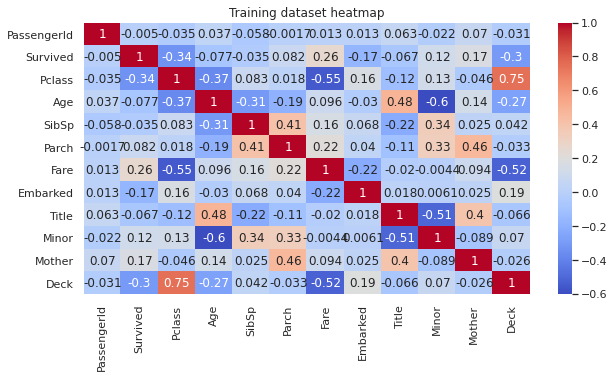

In [42]:
from sklearn.preprocessing import LabelEncoder

plt.figure(figsize=(10,5))
plt.title('Training dataset heatmap')

#label so I can plot in the heatmap
X['Title'] = LabelEncoder().fit_transform(X['Title'])
X['Embarked'] = X['Embarked'].astype('|S') 
X['Embarked'] = LabelEncoder().fit_transform(X['Embarked'])
X['Deck'] = X['Deck'].astype('|S') 
X['Deck'] = LabelEncoder().fit_transform(X['Deck'])
#Check variable correlation
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()

Using 'Title' to fill missing values, it is the better choice  because of its high correlation with 'Age'. In this case, we already saw that mean and median values are not so far from each other, I'll use mean values as the strategy to impute values.

In [43]:
#impute missing age value with mean value and according to passenger title
df['age'] = np.where((df.age.isnull()) & (df.title=="Master"),5,
                        np.where((df.age.isnull()) & (df.title=="Miss"),21,
                                 np.where((df.age.isnull()) & (df.title=="Mr"),33,
                                          np.where((df.age.isnull()) & (df.title=="Mrs"),36, 
                                                       df.age))))

In [44]:
#check if imputing was made
df.isnull().sum()

title        0
name         0
last_name    0
survived     0
sibsp        0
parch        0
age          0
sex          0
dtype: int64

In [45]:
#have a look on surviving rate according to passenger 'title'
df[['title', 'survived']].groupby(['title'], as_index=False).mean()

,title,survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.160149
3,Mrs,0.798450


In [46]:
#apply missing 'age' values to raw dataset
X['Age'] = df['age']

#check if imputing was made
X.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
Minor          0
Mother         0
Deck           0
dtype: int64

In [47]:
#Check if there are still missing values in raw data
X.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
Minor          0
Mother         0
Deck           0
dtype: int64

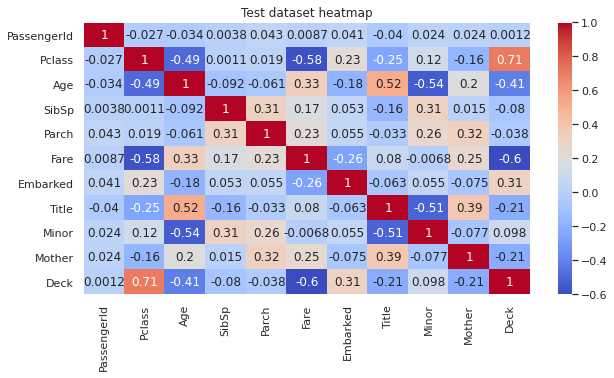

In [48]:
plt.figure(figsize=(10,5))
plt.title('Test dataset heatmap')
#label so I can plot in the heatmap
X_test_full['Title'] = LabelEncoder().fit_transform(X_test_full['Title'])
X_test_full['Embarked'] = X_test_full['Embarked'].astype('|S') 
X_test_full['Embarked'] = LabelEncoder().fit_transform(X_test_full['Embarked'])
X_test_full['Deck'] = X_test_full['Deck'].astype('|S') 
X_test_full['Deck'] = LabelEncoder().fit_transform(X_test_full['Deck'])
#Check variable correlation
sns.heatmap(X_test_full.corr(), annot=True, cmap='coolwarm')
plt.show()

In [49]:
df_test['age'] = np.where((df_test.age.isnull()) & (df_test.title=="Master"),7,
                        np.where((df_test.age.isnull()) & (df_test.title=="Miss"),22,
                                 np.where((df_test.age.isnull()) & (df_test.title=="Mr"),32,
                                          np.where((df_test.age.isnull()) & (df_test.title=="Mrs"),39, 
                                                       df_test.age)))) 

In [50]:
#check if imputing was made
df_test.isnull().sum()

title        0
name         0
last_name    0
age          0
sex          0
dtype: int64

In [51]:
#apply missing 'age' values to test dataset
X_test_full['Age'] = df_test['age'].copy()

#check if imputing was made
X_test_full.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
Minor          0
Mother         0
Deck           0
dtype: int64

Now I'll treat the categorical variables and apply feature engineering mentioned before,
*     New feature 'FamilySize', (already added, 'Title, 'Deck', 'Minor', 'Mother')
*     Prepare all categorical variables with function get_dummies()
*     Drop redundante, non-relevant variables for my model
*     Feature scaling + mean normalization to make sure features are on a similar scale

In [52]:
#Just to have a look on how the data looks at this point
X.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Minor,Mother,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,2,2,0,0,8
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,0,3,0,0,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,2,1,0,0,8
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,2,3,0,0,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,2,2,0,0,8


In [53]:
for df in ([X, X_test_full]):
    df['FamilySize'] = df.SibSp + df.Parch + 1

    #labeling
    df['Fare'] = LabelEncoder().fit_transform(df['Fare'])
    df['Age'] = LabelEncoder().fit_transform(df['Age'])

    #drop old variables
    df.drop(['SibSp'], axis=1, inplace=True)
    df.drop(['Parch'], axis=1, inplace=True)

    #Drop "irrelevant" variables 
    df.drop(['Ticket'], axis=1, inplace=True) # High cardianality variable
    df.drop(['Name'], axis=1, inplace=True) # Feature 'Title' created out of it

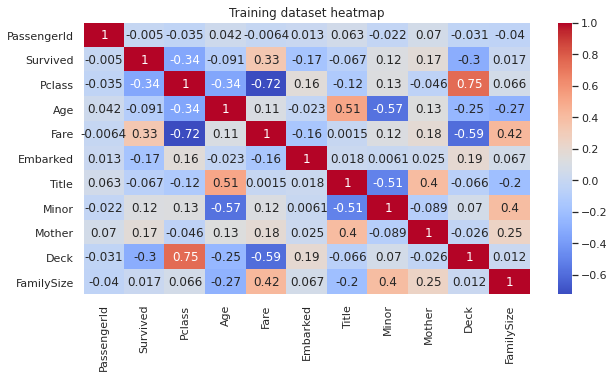

In [54]:
plt.figure(figsize=(10,5))
plt.title('Training dataset heatmap')
#Check variable correlation
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()

Among other features, Pclass and Deck strong correlation suggests me it would be interesting to explore their correlation and maybe I could create another feature for my model.

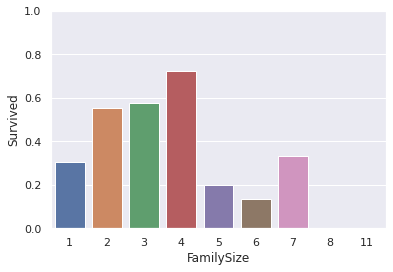

In [55]:
#looking into new 'FamilySize' features:
#plot survivors separated by family size
sns.barplot(x='FamilySize', y='Survived', data=X, ci=None)
plt.ylim(0,1)
plt.show()

In [56]:
X.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Minor,Mother,Deck,FamilySize
0,1,0,3,male,28,18,2,2,0,0,8,2
1,2,1,1,female,51,207,0,3,0,0,2,2
2,3,1,3,female,34,41,2,1,0,0,8,1
3,4,1,1,female,47,189,2,3,0,0,2,2
4,5,0,3,male,47,43,2,2,0,0,8,1


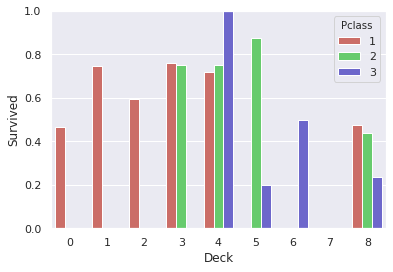

In [57]:
#Exploring Pclass x Deck 
sns.barplot(x='Deck', y='Survived', hue='Pclass', data=X, palette='hls', ci=None);
sns.set()
plt.ylim(0,1)
plt.show()

There is considerable difference in survivability rate when we observe the correlation between ticket class and deck. I'll adress that by creating 'Deck_class' feature. Likewise, I'll create the feature 'Emb_class' addressing the correlation observed in EDA phase.

In [58]:
# New feature 'Deck_class'
X['Deck_class'] = X['Pclass']*X['Deck']
X_test_full['Deck_class'] = X_test_full['Pclass']*X_test_full['Deck']
# New feature 'Emb_class'
X['Emb_class'] = X['Pclass']*X['Embarked']
X_test_full['Emb_class'] = X_test_full['Pclass']*X_test_full['Embarked']

In [59]:
import numpy as np

train_dummies = pd.get_dummies(X, columns=['Sex'])
test_dummies = pd.get_dummies(X_test_full, columns=['Sex'])

X = train_dummies.copy()
X_test_full = test_dummies.copy()

#Feature scaling + normalization
for df in ([X, X_test_full]):
    for col in (['Fare', 'Age', 'FamilySize', 'Deck', 'Title', 'Pclass', 'Deck_class', 'Emb_class']):
        df[col] = (df[col]-df[col].mean())/np.std(df[col])
    df.drop(['Sex_male'], axis=1, inplace=True)  # redundant variable

## Train-CV data split

In [60]:
from sklearn.model_selection import train_test_split

# Separate target from predictors
y = X.Survived              
X.drop(['Survived'], axis=1, inplace=True)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=27)

# **Selecting model**
This is a binary classification problem, so we will try some of the most popular algorithms:
*     Decision Tree Classifier
*     Random Forest Classifier
*     SVM
*     Logistic Regression
*     XGB Classifier
*     Naive Bayes


# **Evaluating model**

In [61]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, auc
from sklearn.metrics import accuracy_score
import scikitplot as skplt
from sklearn.inspection import permutation_importance
#XGB Classifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
#Logistic Regression
from sklearn.linear_model import LogisticRegression
#Decision Tree 
from sklearn.tree import DecisionTreeClassifier
#Random Forest
from sklearn.ensemble import RandomForestClassifier
#SVC
from sklearn.svm import SVC
#Naive Bayes
from sklearn.naive_bayes import GaussianNB 

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve

In [62]:
#result of each model performance stored in Data Frame 'Results'
Results = pd.DataFrame({'Model': [],'Accuracy': [], 'Recall':[], 
                        'Precision':[], 'F1_score':[], 
                        'Roc_Auc':[], 'Log_loss':[],
                        'Positive Samples':[],
                       })

#calculates the performance metrics to evaluate the model
def model_evaluators(y_valid, preds, preds_proba, modelName):
    #True positive (ttp): correct positive prediction
    #False positive (fp): incorrect positive prediction
    #True negative (tn): correct negative prediction
    #False negative (fn): incorrect negative prediction
    tn, fp, fn, tp = confusion_matrix(y_valid, preds).ravel()

    # Accuracy (calculated as the number of all correct predictions divided by the total number of the dataset)
    #          (The best accuracy is 1.0, whereas the worst is 0.0)
    #          (It can also be calculated by 1 – ERR)
    acc_ = (tp + tn) / (tp + tn + fn + fp)
    #note: same as
    #    OR
    #    print("Fraction of correctly classified samples:", "%.5f"% accuracy_score(y_valid, preds))

    # Sensitivity (Recall or true positive rate. 
    #             (How good it is at identifying the positive cases)
    sens_ = tp / (tp + fn)

    # Specificity (selectivity or true negative rate. 
    #             (How good it is at identifyng the negative cases)
    sp_ = tn / (tn + fp)

    # Positive predictive value (PPV or precision. If we say some people died, whats the probability they really did)
    #                           (calculated as the number of correct positive predictions divided by the total number of positive predictions)
    #                           (The best ppv is 1.0, whereas the worst is 0.0)
    PPV = tp / (tp + fp)

    # Negative predictive value (NPV. If we say some people didn't die, whats the probability they really didn't)
    NPV = tn / (tn + fn)

    # F1 score (considers both precision and recall to compute score)
    # (Is the harmonic mean of the precision and recall, best value is 1 (perfect presicion and recall))
    F1 = 2*(PPV*sens_)/(PPV+sens_)
    #note: or 
    #    from sklearn.metrics import f1_score
    #    print(f1_score(y_valid, preds))

    #ROC(Receiver Operating Characteristic)
    fpr, tpr, thr = metrics.roc_curve(y_valid, preds_proba)
    #fpr = 1- specifity
    #tpr = sensitivity
    #thr = thresholds
    rocauc = auc(fpr, tpr)

    # Log loss (good metric for comparing models. 
    # For any given problem, a lower log-loss value means better predictions.
    # Log Loss is a slight twist on something called the Likelihood Function. In fact, Log Loss is -1 * the log of the likelihood function. 
    log_loss_ = log_loss(y_valid, preds_proba)

    #Number of correctly classified samples
    correct_guesses = accuracy_score(y_valid, preds, normalize=False)

    res = pd.DataFrame({'Model': [modelName],
                        'Accuracy': ["%.3f"%  acc_], 
                        'Recall':["%.3f"% sens_], 
                        'Precision':["%.3f"%  PPV], 
                        'F1_score':["%.3f"% F1], 
                        'Roc_Auc':["%.3f"% rocauc], 
                        'Log_loss':["%.3f"% log_loss_],
                        'Positive Samples':[correct_guesses]
                        })
    return res

In [63]:
predictors = [i for i in X_train.columns if i not in ['PassengerId']]

def modelfit_eval(clf, X_train, y_train, X_valid, y_valid, predictors, clf_name):
    model = clf
    
    # Preprocessing of training data, fit model 
    model.fit(X_train[predictors], y_train)

    # Preprocessing of validation data, get predictions
    preds = model.predict(X_valid[predictors])

    # For evaluation step usage
    preds_proba = model.predict_proba(X_valid[predictors])[:, 1]

    #storing for learning curve
    model_xgb = model

    res = model_evaluators(y_valid, preds, preds_proba, clf_name)
    
    return model, res

#Fitting and evaluating models not tuned
model_xgb, res = modelfit_eval(XGBClassifier(), X_train, y_train, X_valid, y_valid, predictors, 'XGB Classifier')
Results = Results.append(res, ignore_index=True)

model_log, res = modelfit_eval(LogisticRegression(solver='liblinear'), X_train, y_train, X_valid, y_valid, predictors, 'Logistic Regression')
Results = Results.append(res, ignore_index=True)

model_dtree, res = modelfit_eval(DecisionTreeClassifier(), X_train, y_train, X_valid, y_valid, predictors, 'Decision Tree Classifier')
Results = Results.append(res, ignore_index=True)

model_rf, res = modelfit_eval(RandomForestClassifier(), X_train, y_train, X_valid, y_valid, predictors, 'Random Forest Classifier')
Results = Results.append(res, ignore_index=True)

model_svm, res = modelfit_eval(SVC(gamma=0.001, probability=True), X_train, y_train, X_valid, y_valid, predictors, 'SVC')
Results = Results.append(res, ignore_index=True)
#Note: SVM's classifiers don't have probabilistic meaning in their nature. For more details refer to: https://www.kaggle.com/c/home-credit-default-risk/discussion/63499

model_nb, res = modelfit_eval(GaussianNB(), X_train, y_train, X_valid, y_valid, predictors, 'Gaussian Naive Bayes')
Results = Results.append(res, ignore_index=True)

#Overall models performance
Results

,Model,Accuracy,Recall,Precision,F1_score,Roc_Auc,Log_loss,Positive Samples
0,XGB Classifier,0.832,0.743,0.798,0.769,0.857,0.535,223.0
1,Logistic Regression,0.802,0.703,0.755,0.728,0.861,0.437,215.0
2,Decision Tree Classifier,0.754,0.693,0.667,0.680,0.733,8.400,202.0
3,Random Forest Classifier,0.825,0.733,0.787,0.759,0.859,0.801,221.0
4,SVC,0.709,0.396,0.702,0.506,0.795,0.546,190.0
5,Gaussian Naive Bayes,0.772,0.762,0.675,0.716,0.820,1.144,207.0


### Learning curves to check on bias vs variance

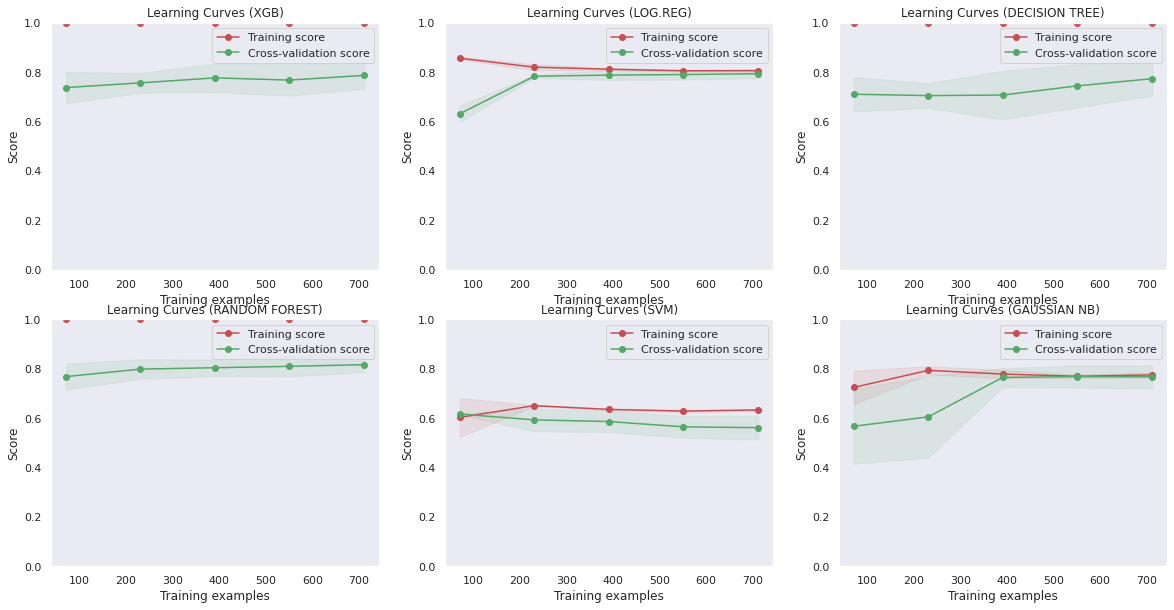

In [64]:
#Plot learning curves 
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, axes=None):
    """
    reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
    """
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axes.set_title(title)
    axes.set_ylim(0,1)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

#Plotting learning curves
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

title = "Learning Curves (XGB)"
plot_learning_curve(model_xgb, title, axes=axes[0, 0])

title = "Learning Curves (LOG.REG)"
plot_learning_curve(model_log, title, axes=axes[0, 1])

title = "Learning Curves (DECISION TREE)"
plot_learning_curve(model_dtree, title, axes=axes[0, 2])

title = "Learning Curves (RANDOM FOREST)"
plot_learning_curve(model_rf, title, axes=axes[1, 0])

title = "Learning Curves (SVM)"
plot_learning_curve(model_svm, title, axes=axes[1, 1])

title = "Learning Curves (GAUSSIAN NB)"
plot_learning_curve(model_nb, title, axes=axes[1, 2])

plt.show()

# Hyperparameter Tuning
>Step 1: Fix learning rate and number of estimators for tuning tree-based parameters

In [65]:
#help create XGBoost models
def modelfit(model, X_train, y_train, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train[predictors].values, 
                              label=y_train.values)
        cvresult = xgb.cv(xgb_param, 
                          xgtrain, 
                          num_boost_round=model.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics='auc',  
                          early_stopping_rounds=early_stopping_rounds)
        model.set_params(n_estimators=cvresult.shape[0])
        
        #'cvresults' is a dataframe with the number of rows being equal to the optimum number of parameters selected. 
        print("Best iteration:", cvresult.shape[0])
        print(cvresult.tail(1))
    
    #Fit the algorithm on the data
    model.fit(X_train[predictors], y_train, eval_metric='auc')
        
    #Predict training set:
    predictions = model.predict(X_train[predictors])
    predprob = model.predict_proba(X_train[predictors])[:,1]
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, predprob))
                    
    feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

Best iteration: 3
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
2        0.898975        0.00943       0.885718      0.034401

Model Report
Accuracy : 0.8411
AUC Score (Train): 0.894327


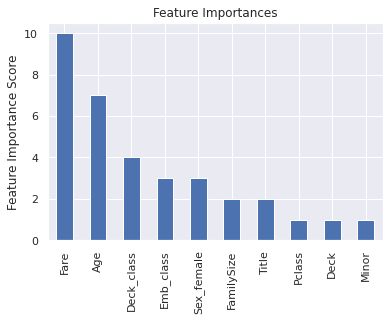

In [66]:
#Choose all predictors except target & 'PassengerId'
#predictors = [i for i in X_train.columns if i not in ['PassengerId']]

#initially
#    max_depth = 4 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.
#    min_child_weight = 0 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
#    gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
#    subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.
#    scale_pos_weight = 1: Because of high class imbalance.
xgb1 = XGBClassifier(learning_rate =0.1,
                     n_estimators=1000,
                     max_depth=4, 
                     min_child_weight=0, 
                     gamma=0, 
                     subsample=0.8, 
                     colsample_bytree=0.8, 
                     objective= 'binary:logistic', 
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)

modelfit(xgb1, X_train, y_train, predictors)

>Step 2: Tune max_depth and min_child_weight

In [67]:
param_test1 = {'max_depth':range(3,10,1),
               'min_child_weight':range(0,6,1)}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=3,
                                                  max_depth=4,
                                                  min_child_weight=0, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  nthread=4, 
                                                  scale_pos_weight=1, 
                                                  seed=27),
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=4, 
                        cv=5)

gsearch1.fit(X_train[predictors],y_train)

#print the results from cv_results_ as they were in grid_scores_
def grid_scores(model):
    print("Best parameters set found on development set:")
    print(model.best_params_)

    print("\nGrid scores on development set:")
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']

    #THIS IS WHAT YOU WANT
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        
grid_scores(gsearch1)

Best parameters set found on development set:
{'max_depth': 4, 'min_child_weight': 1}

Grid scores on development set:
0.873 (+/-0.055) for {'max_depth': 3, 'min_child_weight': 0}
0.873 (+/-0.052) for {'max_depth': 3, 'min_child_weight': 1}
0.870 (+/-0.054) for {'max_depth': 3, 'min_child_weight': 2}
0.865 (+/-0.047) for {'max_depth': 3, 'min_child_weight': 3}
0.860 (+/-0.052) for {'max_depth': 3, 'min_child_weight': 4}
0.861 (+/-0.054) for {'max_depth': 3, 'min_child_weight': 5}
0.877 (+/-0.058) for {'max_depth': 4, 'min_child_weight': 0}
0.878 (+/-0.063) for {'max_depth': 4, 'min_child_weight': 1}
0.876 (+/-0.055) for {'max_depth': 4, 'min_child_weight': 2}
0.875 (+/-0.058) for {'max_depth': 4, 'min_child_weight': 3}
0.867 (+/-0.058) for {'max_depth': 4, 'min_child_weight': 4}
0.862 (+/-0.062) for {'max_depth': 4, 'min_child_weight': 5}
0.874 (+/-0.058) for {'max_depth': 5, 'min_child_weight': 0}
0.866 (+/-0.062) for {'max_depth': 5, 'min_child_weight': 1}
0.872 (+/-0.049) for {'max_

>Step 3: Tune gamma

Now lets tune gamma value using the parameters already tuned above.

In [68]:
param_test3 = {'gamma':[i/10.0 for i in range(0,10)]}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=3, 
                                                  max_depth=4,
                                                  min_child_weight=1,
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8, 
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=27), 
                        param_grid = param_test3, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
gsearch3.fit(X_train[predictors],y_train)
grid_scores(gsearch3)

Best parameters set found on development set:
{'gamma': 0.6}

Grid scores on development set:
0.878 (+/-0.063) for {'gamma': 0.0}
0.878 (+/-0.063) for {'gamma': 0.1}
0.878 (+/-0.064) for {'gamma': 0.2}
0.877 (+/-0.064) for {'gamma': 0.3}
0.878 (+/-0.063) for {'gamma': 0.4}
0.878 (+/-0.064) for {'gamma': 0.5}
0.878 (+/-0.063) for {'gamma': 0.6}
0.877 (+/-0.058) for {'gamma': 0.7}
0.877 (+/-0.058) for {'gamma': 0.8}
0.877 (+/-0.059) for {'gamma': 0.9}


Before proceeding, a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.

Best iteration: 8
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
7        0.907356        0.00523       0.882412      0.038122

Model Report
Accuracy : 0.8684
AUC Score (Train): 0.899970


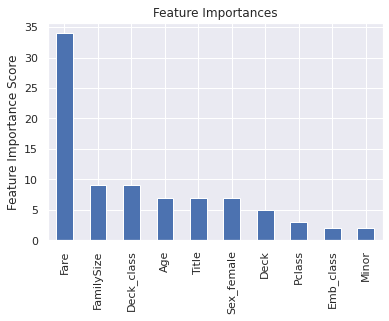

In [69]:
xgb2 = XGBClassifier(learning_rate =0.1, 
                     n_estimators=1000,  
                     max_depth=4,
                     min_child_weight=1,
                     gamma=0.6,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)
modelfit(xgb2, X_train, y_train, predictors)

>Step 4: Tune subsample and colsample_bytree

The next step would be try different subsample and colsample_bytree values. Lets do this in 2 stages as well and take values 0.6,0.7,0.8,0.9 for both to start with.

In [70]:
param_test4 = {'subsample':[i/10.0 for i in range(6,10)],
               'colsample_bytree':[i/10.0 for i in range(6,10)]}

gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=8, 
                                                  max_depth=4,
                                                  min_child_weight=1,
                                                  gamma=0.6,
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  seed=27), 
                        param_grid = param_test4, 
                        scoring='roc_auc',
                        n_jobs=4, 
                        cv=5)
gsearch4.fit(X_train[predictors], y_train)
grid_scores(gsearch4)

Best parameters set found on development set:
{'colsample_bytree': 0.8, 'subsample': 0.9}

Grid scores on development set:
0.873 (+/-0.044) for {'colsample_bytree': 0.6, 'subsample': 0.6}
0.872 (+/-0.052) for {'colsample_bytree': 0.6, 'subsample': 0.7}
0.877 (+/-0.052) for {'colsample_bytree': 0.6, 'subsample': 0.8}
0.878 (+/-0.050) for {'colsample_bytree': 0.6, 'subsample': 0.9}
0.873 (+/-0.050) for {'colsample_bytree': 0.7, 'subsample': 0.6}
0.876 (+/-0.061) for {'colsample_bytree': 0.7, 'subsample': 0.7}
0.878 (+/-0.054) for {'colsample_bytree': 0.7, 'subsample': 0.8}
0.874 (+/-0.058) for {'colsample_bytree': 0.7, 'subsample': 0.9}
0.875 (+/-0.076) for {'colsample_bytree': 0.8, 'subsample': 0.6}
0.874 (+/-0.062) for {'colsample_bytree': 0.8, 'subsample': 0.7}
0.881 (+/-0.066) for {'colsample_bytree': 0.8, 'subsample': 0.8}
0.882 (+/-0.063) for {'colsample_bytree': 0.8, 'subsample': 0.9}
0.870 (+/-0.060) for {'colsample_bytree': 0.9, 'subsample': 0.6}
0.875 (+/-0.057) for {'colsample

Now we should try values in 0.05 interval around these.

In [71]:
param_test5 = {'subsample':[i/100.0 for i in range(85,100,5)],
               'colsample_bytree':[i/100.0 for i in range(75,90,5)]}

gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=8, 
                                                  max_depth=4,
                                                  min_child_weight=1,
                                                  gamma=0.6,
                                                  subsample=0.9, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=27), 
                        param_grid = param_test5, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
gsearch5.fit(X_train[predictors],y_train)
grid_scores(gsearch5)

Best parameters set found on development set:
{'colsample_bytree': 0.75, 'subsample': 0.9}

Grid scores on development set:
0.881 (+/-0.057) for {'colsample_bytree': 0.75, 'subsample': 0.85}
0.882 (+/-0.063) for {'colsample_bytree': 0.75, 'subsample': 0.9}
0.877 (+/-0.053) for {'colsample_bytree': 0.75, 'subsample': 0.95}
0.881 (+/-0.057) for {'colsample_bytree': 0.8, 'subsample': 0.85}
0.882 (+/-0.063) for {'colsample_bytree': 0.8, 'subsample': 0.9}
0.877 (+/-0.053) for {'colsample_bytree': 0.8, 'subsample': 0.95}
0.873 (+/-0.052) for {'colsample_bytree': 0.85, 'subsample': 0.85}
0.876 (+/-0.051) for {'colsample_bytree': 0.85, 'subsample': 0.9}
0.872 (+/-0.050) for {'colsample_bytree': 0.85, 'subsample': 0.95}


>Step 5: Tuning Regularization Parameters

Next step is to apply regularization to reduce overfitting. Though many people don’t use this parameters much as gamma provides a substantial way of controlling complexity. But we should always try it. I’ll tune ‘reg_alpha’ value here and leave it upto you to try different values of ‘reg_lambda’.

In [72]:
param_test6 = {'reg_alpha':[1e-5, 0.0005, 1e-2, 0.1, 0.5, 1, 100]}

gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=8, 
                                                  max_depth=4,
                                                  min_child_weight=1,
                                                  gamma=0.6,
                                                  subsample=0.9, 
                                                  colsample_bytree=0.75,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=27), 
                        param_grid = param_test6, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
gsearch6.fit(X_train[predictors],y_train)
grid_scores(gsearch6)

Best parameters set found on development set:
{'reg_alpha': 1e-05}

Grid scores on development set:
0.882 (+/-0.063) for {'reg_alpha': 1e-05}
0.882 (+/-0.063) for {'reg_alpha': 0.0005}
0.881 (+/-0.063) for {'reg_alpha': 0.01}
0.881 (+/-0.064) for {'reg_alpha': 0.1}
0.880 (+/-0.063) for {'reg_alpha': 0.5}
0.880 (+/-0.060) for {'reg_alpha': 1}
0.500 (+/-0.000) for {'reg_alpha': 100}


In [73]:
param_test7 = {'reg_alpha':[1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 1e-02]}

gsearch7 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=8, 
                                                  max_depth=4,
                                                  min_child_weight=1,
                                                  gamma=0.6,
                                                  subsample=0.9, 
                                                  colsample_bytree=0.75,                                                  
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=27),
                        param_grid = param_test7, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)

gsearch7.fit(X_train[predictors],y_train)
grid_scores(gsearch7)

Best parameters set found on development set:
{'reg_alpha': 1e-07}

Grid scores on development set:
0.882 (+/-0.063) for {'reg_alpha': 1e-07}
0.882 (+/-0.063) for {'reg_alpha': 1e-06}
0.882 (+/-0.063) for {'reg_alpha': 1e-05}
0.882 (+/-0.063) for {'reg_alpha': 0.0001}
0.882 (+/-0.063) for {'reg_alpha': 0.001}
0.881 (+/-0.063) for {'reg_alpha': 0.01}


Now we can apply this regularization in the model and look at the impact:

Best iteration: 8
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
7        0.905262       0.006865       0.880627      0.042678

Model Report
Accuracy : 0.8555
AUC Score (Train): 0.899188


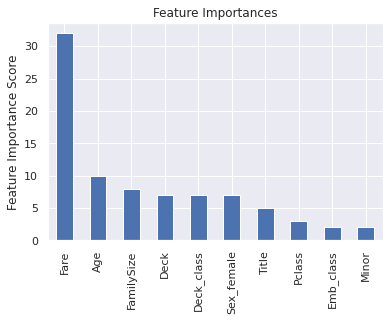

In [74]:
xgb3 = XGBClassifier(learning_rate =0.1, 
                     n_estimators=8, 
                     max_depth=4,
                     min_child_weight=1,
                     gamma=0.6,
                     subsample=0.9, 
                     colsample_bytree=0.75,
                     reg_alpha=1e-07,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)

modelfit(xgb3, X_train, y_train, predictors)

>Step 6: Reducing Learning Rate

Lastly, we should lower the learning rate and add more trees. Lets use the cv function of XGBoost to do the job again.

Best iteration: 81
    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
80        0.908126       0.007407       0.883221      0.037561

Model Report
Accuracy : 0.8427
AUC Score (Train): 0.906335


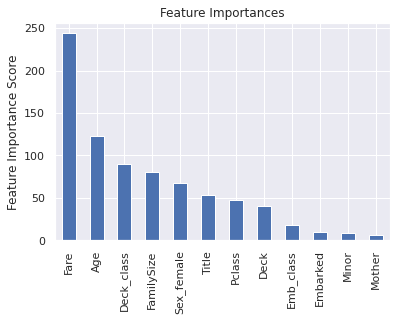

In [75]:
xgb4 = XGBClassifier(learning_rate =0.001, 
                     n_estimators=200,  
                     max_depth=4,
                     min_child_weight=1,
                     gamma=0.6,
                     subsample=0.9, 
                     colsample_bytree=0.75,
                     reg_alpha=1e-07,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)
modelfit(xgb4, X_train, y_train, predictors)

In [76]:
#XGBClassifier
from xgboost import XGBClassifier

# Define model
model_xgb = xgb4

# Preprocessing of training data, fit model 
model_xgb.fit(X_train[predictors], y_train)

# Preprocessing of validation data, get predictions
preds = model_xgb.predict(X_valid[predictors])

# For evaluation step usage
preds_proba = model_xgb.predict_proba(X_valid[predictors])[:, 1]

res = model_evaluators(y_valid, preds, preds_proba, 'Hyperparametarized XGB')
Results = Results.append(res, ignore_index=True)

#Overall models performance
Results

,Model,Accuracy,Recall,Precision,F1_score,Roc_Auc,Log_loss,Positive Samples
0,XGB Classifier,0.832,0.743,0.798,0.769,0.857,0.535,223.0
1,Logistic Regression,0.802,0.703,0.755,0.728,0.861,0.437,215.0
2,Decision Tree Classifier,0.754,0.693,0.667,0.680,0.733,8.400,202.0
3,Random Forest Classifier,0.825,0.733,0.787,0.759,0.859,0.801,221.0
4,SVC,0.709,0.396,0.702,0.506,0.795,0.546,190.0
5,Gaussian Naive Bayes,0.772,0.762,0.675,0.716,0.820,1.144,207.0
6,Hyperparametarized XGB,0.821,0.693,0.805,0.745,0.869,0.658,220.0


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

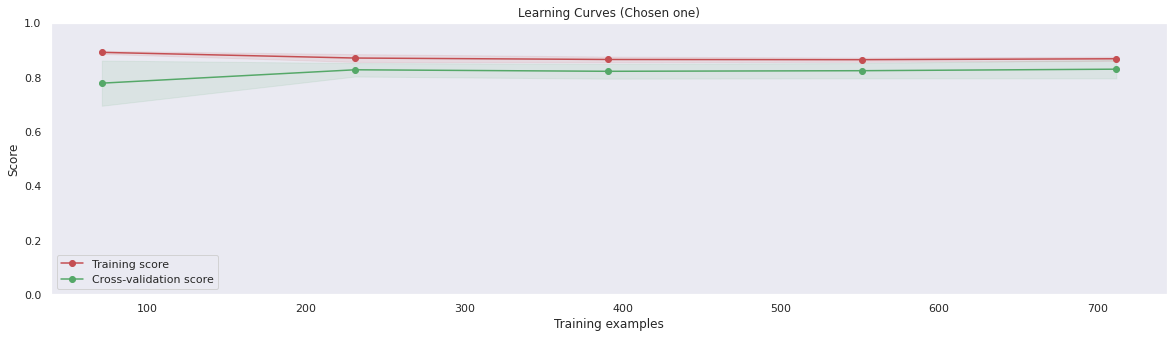

In [77]:
title = "Learning Curves (Chosen one)" 
plot_learning_curve(model_xgb, title, axes=None)

After tuning, there was an improvement on the learning curve, the cross validation score wasn't steadly getting closer to the training score nor higher, after tuning you can see that it is close to the training score. The numerical metrics also shown slight improvement. 

In [78]:
## Search grid for optimal parameters
rf_grid_param = {'n_estimators': [100, 200, 300, 400],
                 'max_features': ['auto', 'sqrt', 'log2'],
                 'max_depth': [4, 5, 7, None],
                 'min_samples_split': [2, 3, 5, 7],
                 'min_samples_leaf': [1, 3, 5, 7]}
dt_grid_param = {'criterion': ['gini', 'entropy'],
                 'max_features': ['auto', 'sqrt', 'log2'],
                 'max_depth': [4, 5, 7, None],
                 'min_samples_split': [2, 3, 5, 7],
                 'min_samples_leaf': [1, 3, 5, 7]}
log_grid_param = {'penalty': ['l1', 'l2'],
                  'C': np.logspace(-4, 4, 20),
                  'solver': ['liblinear', 'saga']}
nb_grid_param = {'var_smoothing': np.logspace(0,-9, num=100)}

model_rf = RandomizedSearchCV(estimator=model_rf,
                              param_distributions=rf_grid_param,
                              n_iter=300,
                              cv =5,
                              scoring='roc_auc',
                              verbose=2,
                              random_state=27,
                              n_jobs = -1)
model_dtree = RandomizedSearchCV(estimator=model_dtree,
                                 param_distributions=dt_grid_param,
                                 n_iter=300,
                                 cv =5,
                                 scoring='roc_auc',
                                 verbose=1,
                                 random_state=27,
                                 n_jobs = -1)
model_log = RandomizedSearchCV(estimator=model_log, 
                               param_distributions =log_grid_param, 
                               n_iter=300,
                               cv = 5, 
                               scoring='roc_auc',
                               verbose=1, 
                               random_state=27,
                               n_jobs=-1)
model_nb = RandomizedSearchCV(estimator=model_nb, 
                              param_distributions=nb_grid_param, 
                              n_iter=300,
                              cv = 5, 
                              scoring='roc_auc',
                              verbose=1, 
                              random_state=27,
                              n_jobs=-1)

preds_list = []
for model in [model_rf, model_dtree, model_log, model_nb]:
    model.fit(X_train[predictors], y_train)
    model = model.best_estimator_
    preds = model.predict(X_valid[predictors]) # Preprocessing of validation data, get predictions
    preds_proba = model.predict_proba(X_valid[predictors])[:, 1] # For evaluation step usage
    
    clf_name = str(model).split('(')[0]
    res = model_evaluators(y_valid, preds, preds_proba, 'Hyperparametarized '+clf_name)
    Results = Results.append(res, ignore_index=True)
    preds_list.append(preds) #store predictions for confusion matrix

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  5.8min finished


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    4.0s finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 80 is smaller than n_iter=300. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.1s finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 100 is smaller than n_iter=300. Running 100 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.5s finished


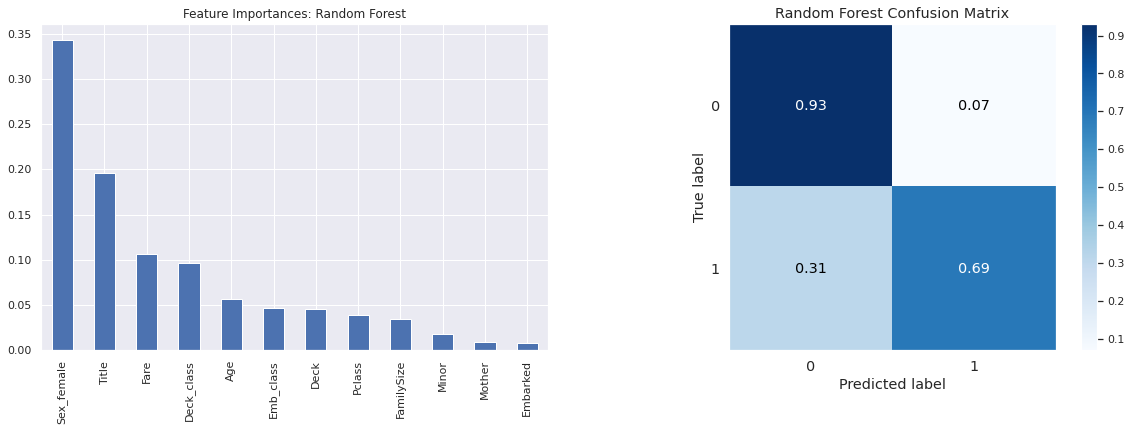

In [79]:
#Feature Importance and Confusion Matrix
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

importances = model_rf.best_estimator_.feature_importances_
feat_imp = pd.Series(importances, index=predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances: Random Forest', ax=ax1)
plt.ylabel('Feature Importance Score')

skplt.metrics.plot_confusion_matrix(y_valid, preds_list[0], title='{} Confusion Matrix'.format('Random Forest'),
                                    normalize=True,text_fontsize='large', ax=ax2 )
plt.show()

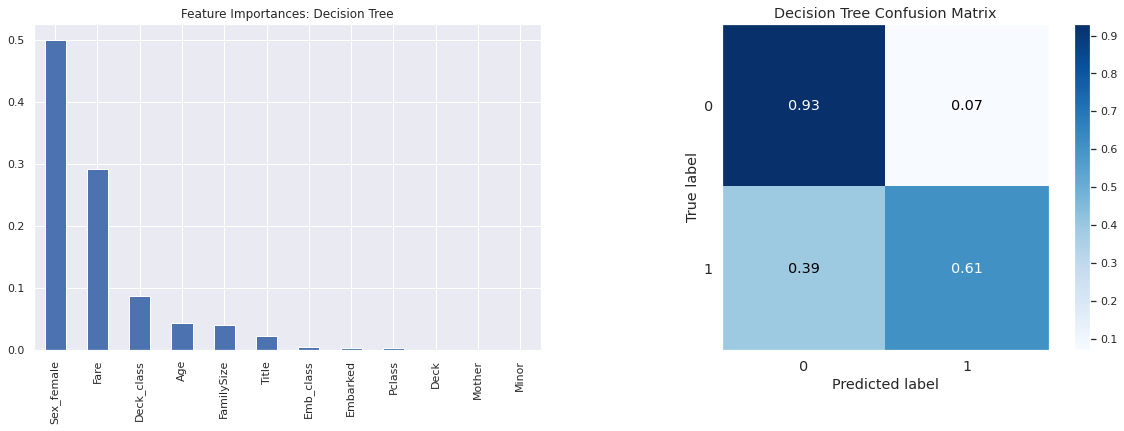

In [80]:
#Feature Importance and Confusion Matrix
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

importances = model_dtree.best_estimator_.feature_importances_
feat_imp = pd.Series(importances, index=predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances: Decision Tree', ax=ax1)
plt.ylabel('Feature Importance Score')

skplt.metrics.plot_confusion_matrix(y_valid, preds_list[1], title='{} Confusion Matrix'.format('Decision Tree'),
                                    normalize=True,text_fontsize='large', ax=ax2 )
plt.show()

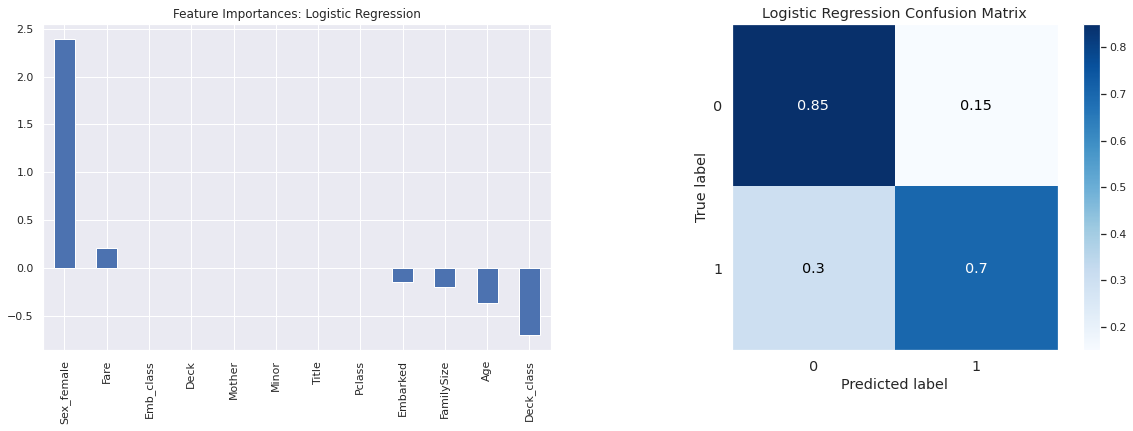

In [81]:
#Feature Importance and Confusion Matrix
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

importances = model_log.best_estimator_.coef_[0]
feat_imp = pd.Series(importances, index=predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances: Logistic Regression', ax=ax1)
plt.ylabel('Feature Importance Score')

skplt.metrics.plot_confusion_matrix(y_valid, preds_list[2], title='{} Confusion Matrix'.format('Logistic Regression'),
                                    normalize=True,text_fontsize='large', ax=ax2 )
plt.show()

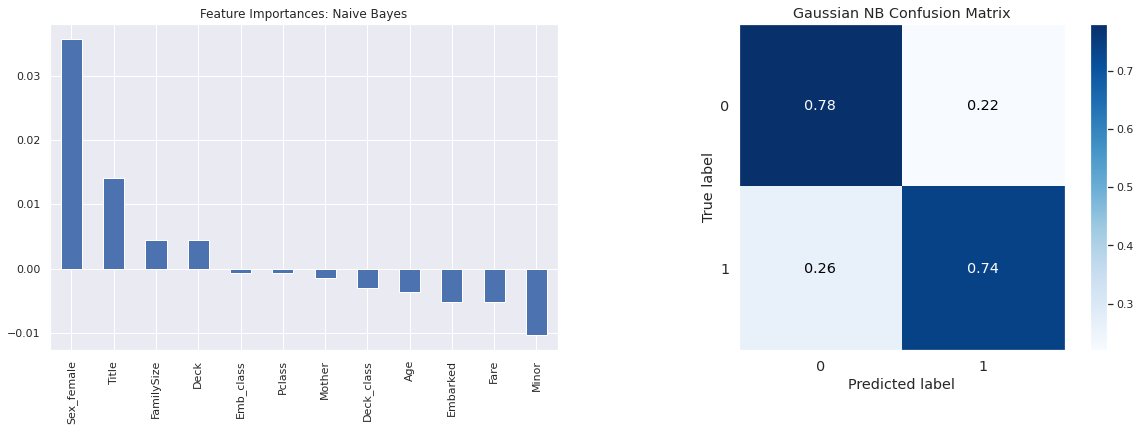

In [82]:
#Feature Importance and Confusion Matrix
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

importances = permutation_importance(model_nb.best_estimator_, X_valid[predictors], y_valid)
feat_imp = pd.Series(importances.importances_mean, index=predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances: Naive Bayes', ax=ax1)
plt.ylabel('Feature Importance Score')

skplt.metrics.plot_confusion_matrix(y_valid, preds_list[3], title='{} Confusion Matrix'.format('Gaussian NB'),
                                    normalize=True,text_fontsize='large', ax=ax2 )
plt.show()

In [83]:
Results

,Model,Accuracy,Recall,Precision,F1_score,Roc_Auc,Log_loss,Positive Samples
0,XGB Classifier,0.832,0.743,0.798,0.769,0.857,0.535,223.0
1,Logistic Regression,0.802,0.703,0.755,0.728,0.861,0.437,215.0
2,Decision Tree Classifier,0.754,0.693,0.667,0.680,0.733,8.400,202.0
3,Random Forest Classifier,0.825,0.733,0.787,0.759,0.859,0.801,221.0
4,SVC,0.709,0.396,0.702,0.506,0.795,0.546,190.0
5,Gaussian Naive Bayes,0.772,0.762,0.675,0.716,0.820,1.144,207.0
6,Hyperparametarized XGB,0.821,0.693,0.805,0.745,0.869,0.658,220.0
7,Hyperparametarized RandomForestClassifier,0.843,0.693,0.864,0.769,0.870,0.420,226.0
8,Hyperparametarized DecisionTreeClassifier,0.810,0.614,0.838,0.709,0.859,1.149,217.0
9,Hyperparametarized LogisticRegression,0.795,0.703,0.740,0.721,0.853,0.454,213.0


# Error Analysis
Let's see if we can find any pattern by examining the examples in cross-validation set that the model made errors on. If we find any systematic trend in what type of example it is making errors we could try tackle it accordingly.

In [84]:
#Error Analysis
preds_proba = model_rf.best_estimator_.predict_proba(X_valid[predictors])[:, 1]
X_valid['preds_proba'] = preds_proba
X_valid['preds'] = preds_list[0]
X_valid['true_preds'] = y_valid

wrong_preds = X_valid.loc[((X_valid.preds == 1) & (X_valid.true_preds == 0)) | 
                          ((X_valid.preds == 0) & (X_valid.true_preds == 1))].sort_values(by=['preds'], 
                                                                                          ascending=False)

X_valid.drop('preds_proba', axis=1, inplace=True)
X_valid.drop('preds', axis=1, inplace=True)
X_valid.drop('true_preds', axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [85]:
wrong_preds.head()

,PassengerId,Pclass,Age,Fare,Embarked,Title,Minor,Mother,Deck,FamilySize,Deck_class,Emb_class,Sex_female,preds_proba,preds,true_preds
772,773,-0.369365,2.019874,-0.476217,2,1.616095,0,0,-1.104373,-0.560975,-1.036023,0.151946,1,0.865014,1,0
617,618,0.827377,-0.303944,0.052028,2,1.616095,0,0,0.522067,0.059160,0.797792,1.031062,1,0.632164,1,0
49,50,0.827377,-0.959380,0.094859,2,1.616095,0,0,0.522067,0.059160,0.797792,1.031062,1,0.628870,1,0
177,178,-1.566107,1.543193,0.623104,0,-1.188074,0,0,-1.917594,-0.560975,-1.723704,-1.606286,1,0.884838,1,0
680,681,0.827377,-0.721040,-0.861694,1,-1.188074,0,0,0.522067,-0.560975,0.797792,-0.287612,1,0.613836,1,0


In [86]:
#Counting occurences
print('Total Error examples:', wrong_preds.shape[0])
print('-------------------------')
print(wrong_preds['preds'].value_counts())
print('-------------------------')
print(wrong_preds['Sex_female'].value_counts())
print('-------------------------')
print(wrong_preds['Embarked'].value_counts())
print('-------------------------')
print(wrong_preds['Pclass'].value_counts())
print('-------------------------')
print(wrong_preds['Title'].value_counts())
print('-------------------------')
print(wrong_preds['Deck'].value_counts())
print('-------------------------')
print(wrong_preds['FamilySize'].value_counts())

Total Error examples: 42
-------------------------
0    31
1    11
Name: preds, dtype: int64
-------------------------
0    28
1    14
Name: Sex_female, dtype: int64
-------------------------
2    28
0    12
1     2
Name: Embarked, dtype: int64
-------------------------
 0.827377    23
-1.566107    16
-0.369365     3
Name: Pclass, dtype: int64
-------------------------
 0.214011    28
 1.616095     9
-1.188074     5
Name: Title, dtype: int64
-------------------------
 0.522067    25
-2.324204     4
-1.917594     4
-1.104373     4
-1.510984     2
-2.730814     2
-0.291153     1
Name: Deck, dtype: int64
-------------------------
-0.560975    27
 0.059160     9
 0.679295     5
 1.299429     1
Name: FamilySize, dtype: int64


Most relevant information according to highest error occurence:
- More men wrongfully predicted than women
- People that Embarked from 'S' (2): Passengers that embarked from Southampton
- Title 'Mr.' (0.214011): Males with Mr. title
- Pclass 3 (0.827377): Third class passengers
- Deck Unknown (0.522067): Unknown decks
- FamilySize 1(-0.560975): Lonely travelers

In [87]:
#Error where: Unknown Decks and Lonely Travellers
print('Unknown Decks and Lonely Travellers:',
      wrong_preds.loc[((wrong_preds.Deck < 0.522068)&(wrong_preds.Deck > 0.522066)) &
                      ((wrong_preds.FamilySize < -0.560974)&(wrong_preds.FamilySize > -0.560976))].shape[0])
#Error where: Lonely Travellers embarked from S and Deck is unknown
print('Unknown Decks Lonely Travellers embarked from Southampton:',
      wrong_preds.loc[((wrong_preds.Deck < 0.522068)&(wrong_preds.Deck > 0.522066)) &
                      (wrong_preds.Embarked == 2) &
                      ((wrong_preds.FamilySize < -0.560974)&(wrong_preds.FamilySize > -0.560976))].shape[0])
#Error where: Mr. and Lonely Travellers
print('Mr.title and Lonely Traveller:',
      wrong_preds.loc[((wrong_preds.Title < 0.214012)&(wrong_preds.Title > 0.214010)) &
                      ((wrong_preds.FamilySize < -0.560974)&(wrong_preds.FamilySize > -0.560976))].shape[0])
#Error where: Lonely Travellers embarked from S
print('Unknown Deck and Embarked from S:',
      wrong_preds.loc[((wrong_preds.Deck < 0.522068)&(wrong_preds.Deck > 0.522066)) &
                      (wrong_preds.Embarked == 2)].shape[0]) 

Unknown Decks and Lonely Travellers: 18
Unknown Decks Lonely Travellers embarked from Southampton: 13
Mr.title and Lonely Traveller: 22
Unknown Deck and Embarked from S: 19


Account error patterns to new features:
- Binary feature: Mr_lonely 
        (1) Mister and lonely traveller 
        (0) otherwise
- Binary feature: Unknown_s    
        (1) Unknown Deck and embarked from Southampton
        (0) otherwise

# Applying Error Analysis discoveries

In [88]:
def f(row):
    if (row['Title'] > 0.214010 and row['Title'] < 0.214012) and (row['FamilySize'] > -0.560976 and row['FamilySize'] < -0.560974): val = 1
    else: val = 0
    return val
#Mister and lonely traveller
X['Mr_lonely'] = X.apply(f, axis=1)
X_test_full['Mr_lonely'] = X_test_full.apply(f, axis=1)

def f(row):
    if (row['Deck'] > 0.522066 and row['Deck'] < 0.522068) and row['Embarked'] == 2: val = 1
    else: val = 0
    return val
#Unknown Deck and embarked from Southampton
X['Unknown_s'] = X.apply(f, axis=1)
X_test_full['Unknown_s'] = X_test_full.apply(f, axis=1)

In [89]:
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=27)
## Search grid for optimal parameters
rf_grid_param = {'n_estimators': [200, 300, 400, 700],
                 'max_features': ['auto', 'sqrt', 'log2'],
                 'max_depth': [4, 5, 7, None],
                 'min_samples_split': [2, 3, 5, 7],
                 'min_samples_leaf': [1, 3, 5, 7]}
model_rf, _ = modelfit_eval(RandomForestClassifier(), X_train, y_train, X_valid, y_valid, predictors, 'Random Forest Classifier')
model_rf = RandomizedSearchCV(estimator=model_rf,
                              param_distributions=rf_grid_param,
                              n_iter=300,
                              cv =5,
                              scoring='roc_auc',
                              verbose=2,
                              random_state=27,
                              n_jobs = -1)

model_rf.fit(X_train[predictors], y_train)
model = model_rf.best_estimator_
preds = model.predict(X_valid[predictors]) # Preprocessing of validation data, get predictions
preds_proba = model.predict_proba(X_valid[predictors])[:, 1] # For evaluation step usage

res = model_evaluators(y_valid, preds, preds_proba, 'Random Forest after Error Analysis')
Results = Results.append(res, ignore_index=True)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  9.1min finished


In [90]:
Results

,Model,Accuracy,Recall,Precision,F1_score,Roc_Auc,Log_loss,Positive Samples
0,XGB Classifier,0.832,0.743,0.798,0.769,0.857,0.535,223.0
1,Logistic Regression,0.802,0.703,0.755,0.728,0.861,0.437,215.0
2,Decision Tree Classifier,0.754,0.693,0.667,0.680,0.733,8.400,202.0
3,Random Forest Classifier,0.825,0.733,0.787,0.759,0.859,0.801,221.0
4,SVC,0.709,0.396,0.702,0.506,0.795,0.546,190.0
5,Gaussian Naive Bayes,0.772,0.762,0.675,0.716,0.820,1.144,207.0
6,Hyperparametarized XGB,0.821,0.693,0.805,0.745,0.869,0.658,220.0
7,Hyperparametarized RandomForestClassifier,0.843,0.693,0.864,0.769,0.870,0.420,226.0
8,Hyperparametarized DecisionTreeClassifier,0.810,0.614,0.838,0.709,0.859,1.149,217.0
9,Hyperparametarized LogisticRegression,0.795,0.703,0.740,0.721,0.853,0.454,213.0


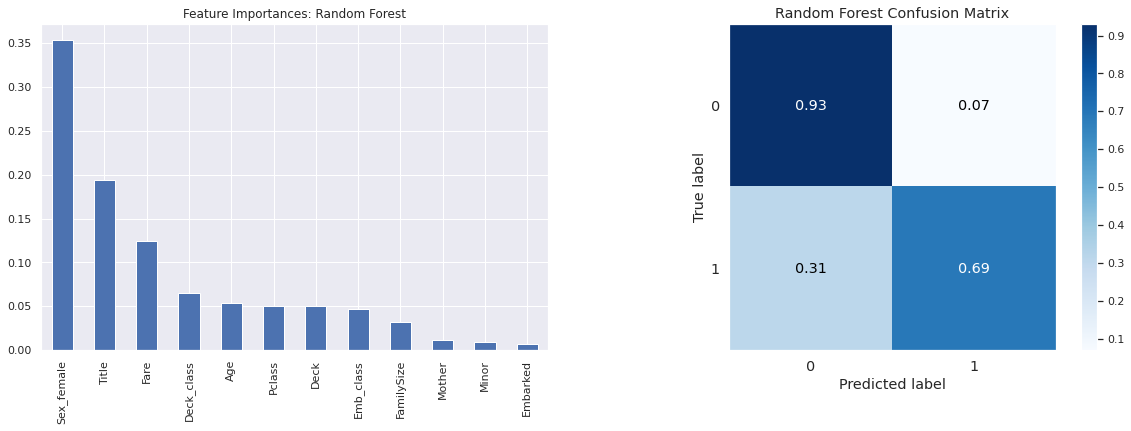

In [91]:
#Feature Importance and Confusion Matrix
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

importances = model_rf.best_estimator_.feature_importances_
feat_imp = pd.Series(importances, index=predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances: Random Forest', ax=ax1)
plt.ylabel('Feature Importance Score')

skplt.metrics.plot_confusion_matrix(y_valid, preds_list[0], title='{} Confusion Matrix'.format('Random Forest'),
                                    normalize=True,text_fontsize='large', ax=ax2 )
plt.show()

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

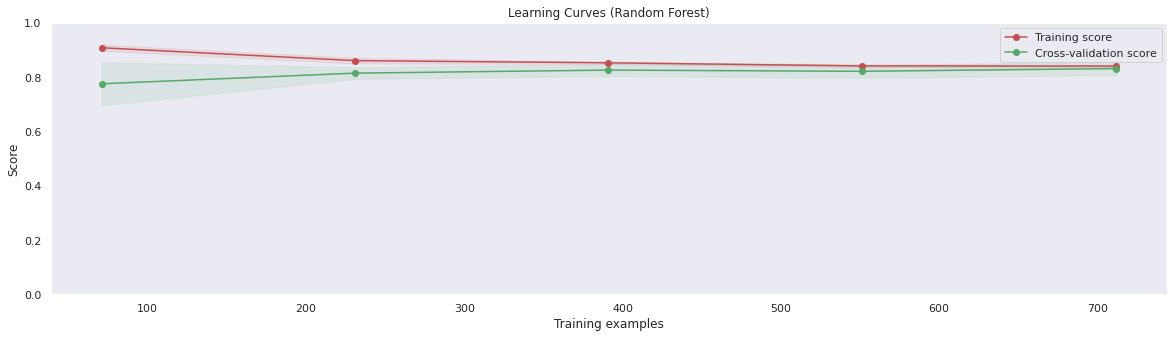

In [92]:
title = "Learning Curves (Random Forest)" 
plot_learning_curve(model, title, axes=None)

# **Chosen model**

In [93]:
model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# **Get predictions**

In [94]:
# Preprocessing of test data, fit model 
preds_test = model.predict(X_test_full[predictors])

#Saving Submission file
output = pd.DataFrame({'PassengerId': X_test_full.PassengerId, 'Survived': preds_test})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


# Final Notes for this version
* It's worth mentioning I tried different ideas before getting here and learned from others in the community, there are many other ways to approach this classification problem. 
* In this version applying the findings from Error Analysis didn't convert to a higher accuracy, but on test set it did make a slighly better performance. There is still room to do a more sophisticated analysis. 
* For a next version I could define better Age and FamilySize segregating/narrowing the feature labels.
* Hyperparameter tuning is consiredably important to push the model to a higher accuracy one. 
* Feature engineering is very important and plays a big role on designing a high accuracy learning system in Titanic. Doing Error Analysis helps to take more systematic decisions to develop new ideas to further improve the model. 
* My suggestion: Start with a simple algorithm that you can implement quickly (You can check earlier versions of this kernel to get an idea). Implement it and test it on your validation data. Use evidance to guide you where to spend your time in (like learning curves and numerical metrics). Do error analysis and see if you spot any systematic trend. Bring life to your analysis! 